In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import joblib

In [65]:
# === Load and preprocess data ===
data = pd.read_csv("data/crude_oil_macro_data.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [68]:
# === Target variable ===
target = data['Close_CL=F'].fillna(method='ffill')
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

<ipython-input-68-088bd2785170>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target = data['Close_CL=F'].fillna(method='ffill')


In [69]:
# === Create sequences ===
def create_sequences(data, seq_length):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(data)):
        X_seq.append(data[i-seq_length:i, 0])
        y_seq.append(data[i, 0])
    return np.array(X_seq), np.array(y_seq)

seq_len = 60
X_seq, y_seq = create_sequences(target_scaled, seq_len)
X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], 1))

In [70]:
# === Train/test split ===
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [71]:
# === Build model ===
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 614ms/step - loss: 0.2815 - val_loss: 0.1901
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1695 - val_loss: 0.0514
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0836 - val_loss: 0.0084
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0559 - val_loss: 0.0838
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0643 - val_loss: 0.0415
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0479 - val_loss: 0.0073
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0357 - val_loss: 0.0027
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0411 - val_loss: 0.0074
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0443 - val_loss: 0.0099
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0437 - val_loss: 0.0071
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0437 - val_loss: 0.0034
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.0408 - val_lo

In [72]:
# === Evaluate ===
predicted = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print(f"\n✅ LSTM RMSE: {rmse:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step

✅ LSTM RMSE: 0.0505


In [73]:
# === Inverse transform predictions ===
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_actual = scaler.inverse_transform(predicted)


In [74]:
# === Save model and scaler ===
os.makedirs("models", exist_ok=True)
model.save("models/lstm_model.h5")
joblib.dump(scaler, "models/lstm_scaler.save")


['models/lstm_scaler.save']

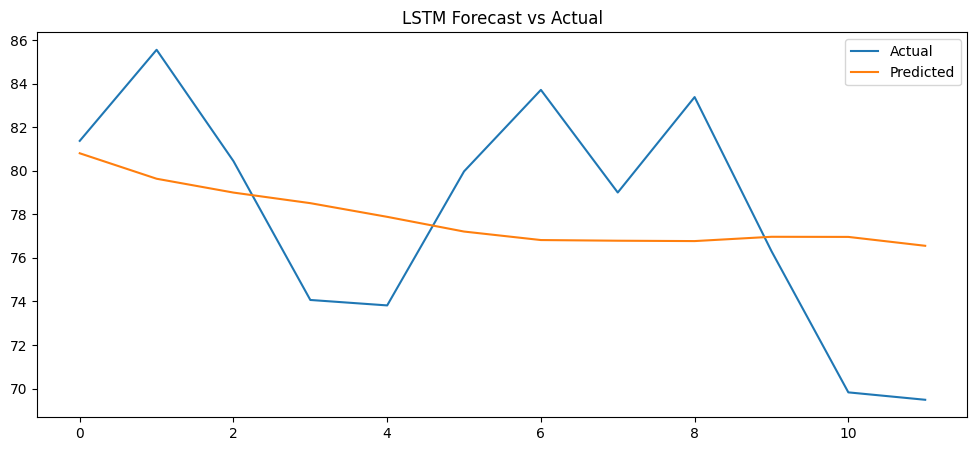

In [75]:
# === Plot ===
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label='Actual')
plt.plot(predicted_actual, label='Predicted')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.savefig("models/lstm_forecast_plot.png")
plt.show()